In [1]:
import shutil

src = '/kaggle/input/ch-resnet50-wts/chft-ResNet50.pth'
dst = '/kaggle/working/chft-ResNet50.pth'

shutil.copy(src, dst)

'/kaggle/working/chft-ResNet50.pth'

2025-07-04 17:39:10.475259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751650750.653324      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751650750.707807      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda:0


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


✅ Loaded best checkpoint from /kaggle/working/chft-ResNet50.pth
Training with mixed precision (AMP)…
Epoch [1/100]  tloss: 0.4467  tacc: 81.44%  vloss: 2.4111  vacc: 80.17%  lr: 1e-03  time: 1m 56s
→ New best validation accuracy: 80.17% at epoch 1
Epoch [2/100]  tloss: 0.1016  tacc: 98.52%  vloss: 0.0723  vacc: 98.10%  lr: 1e-03  time: 1m 51s
→ New best validation accuracy: 98.10% at epoch 2
Epoch [3/100]  tloss: 0.0378  tacc: 99.33%  vloss: 0.0513  vacc: 98.28%  lr: 1e-03  time: 1m 50s
→ New best validation accuracy: 98.28% at epoch 3
Epoch [4/100]  tloss: 0.0398  tacc: 98.85%  vloss: 0.1019  vacc: 97.93%  lr: 1e-03  time: 1m 54s
No improvement. Patience: 1/10
Epoch [5/100]  tloss: 0.0229  tacc: 99.74%  vloss: 0.0330  vacc: 98.45%  lr: 1e-03  time: 1m 52s
→ New best validation accuracy: 98.45% at epoch 5
Epoch [6/100]  tloss: 0.0221  tacc: 99.85%  vloss: 0.0433  vacc: 98.10%  lr: 1e-03  time: 1m 51s
No improvement. Patience: 1/10
Epoch [7/100]  tloss: 0.0400  tacc: 98.30%  vloss: 0.06

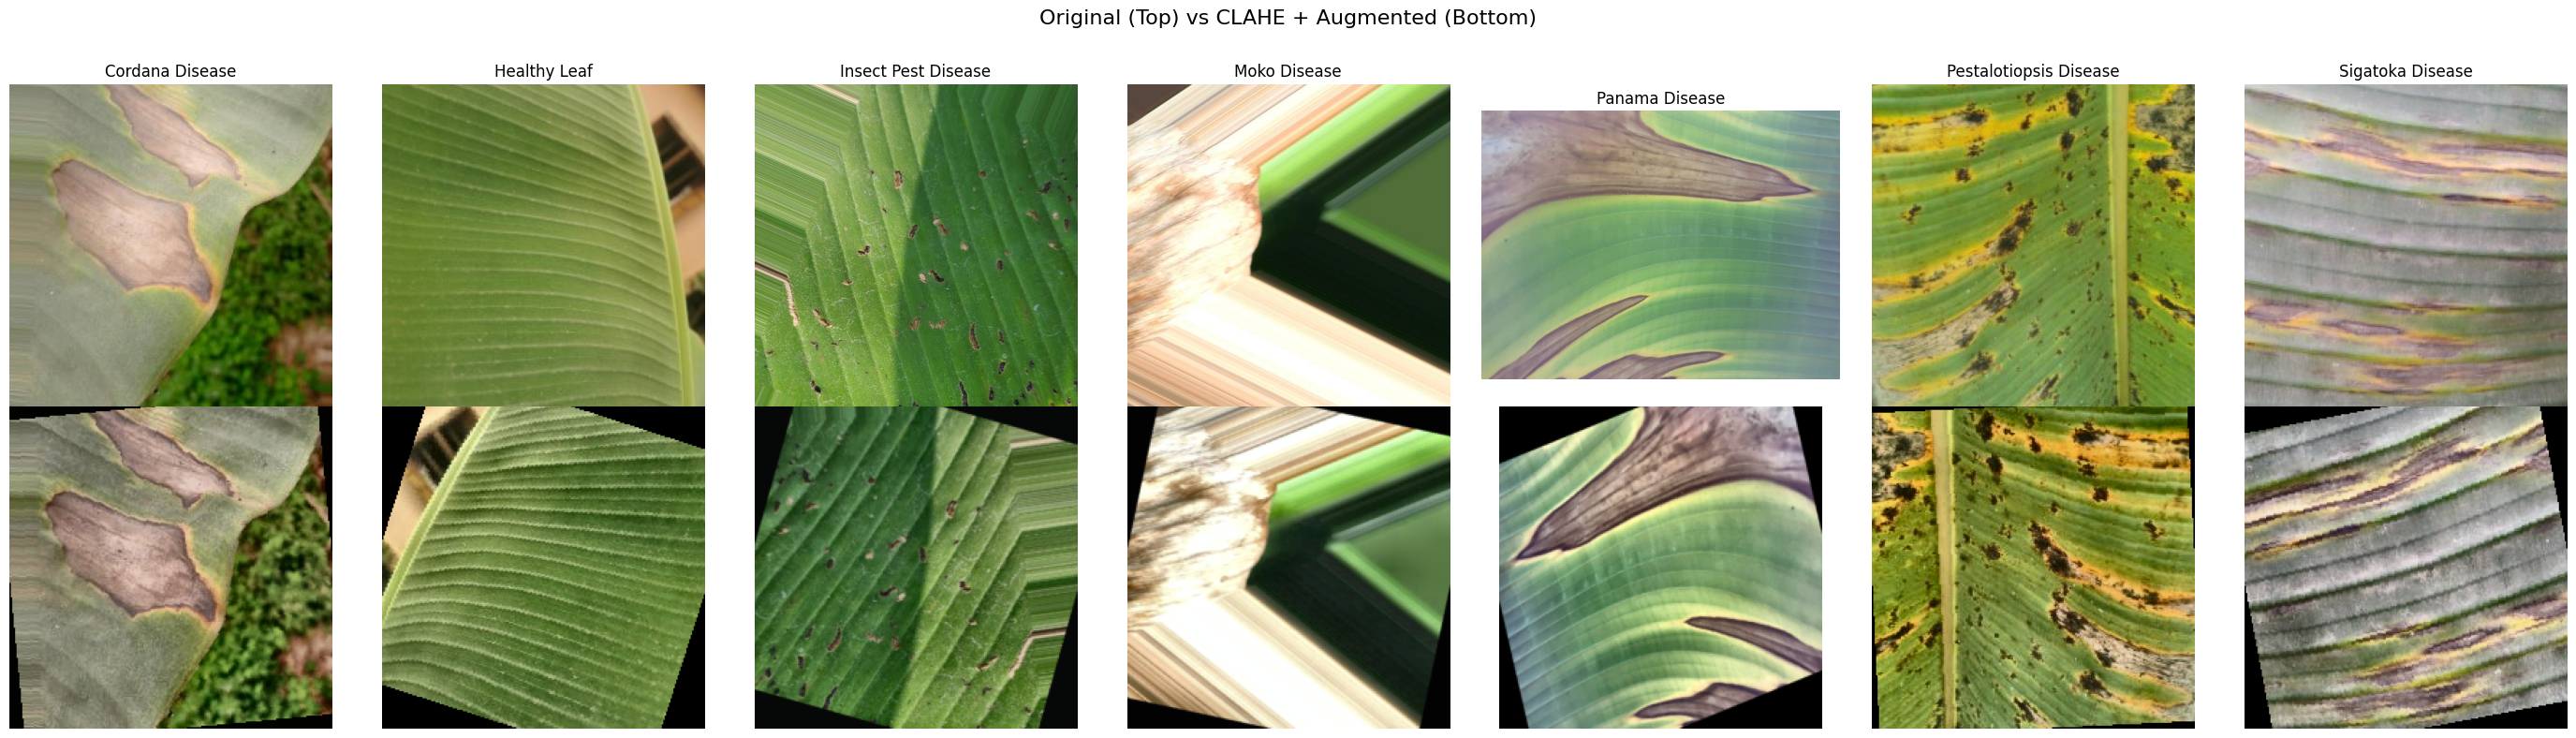

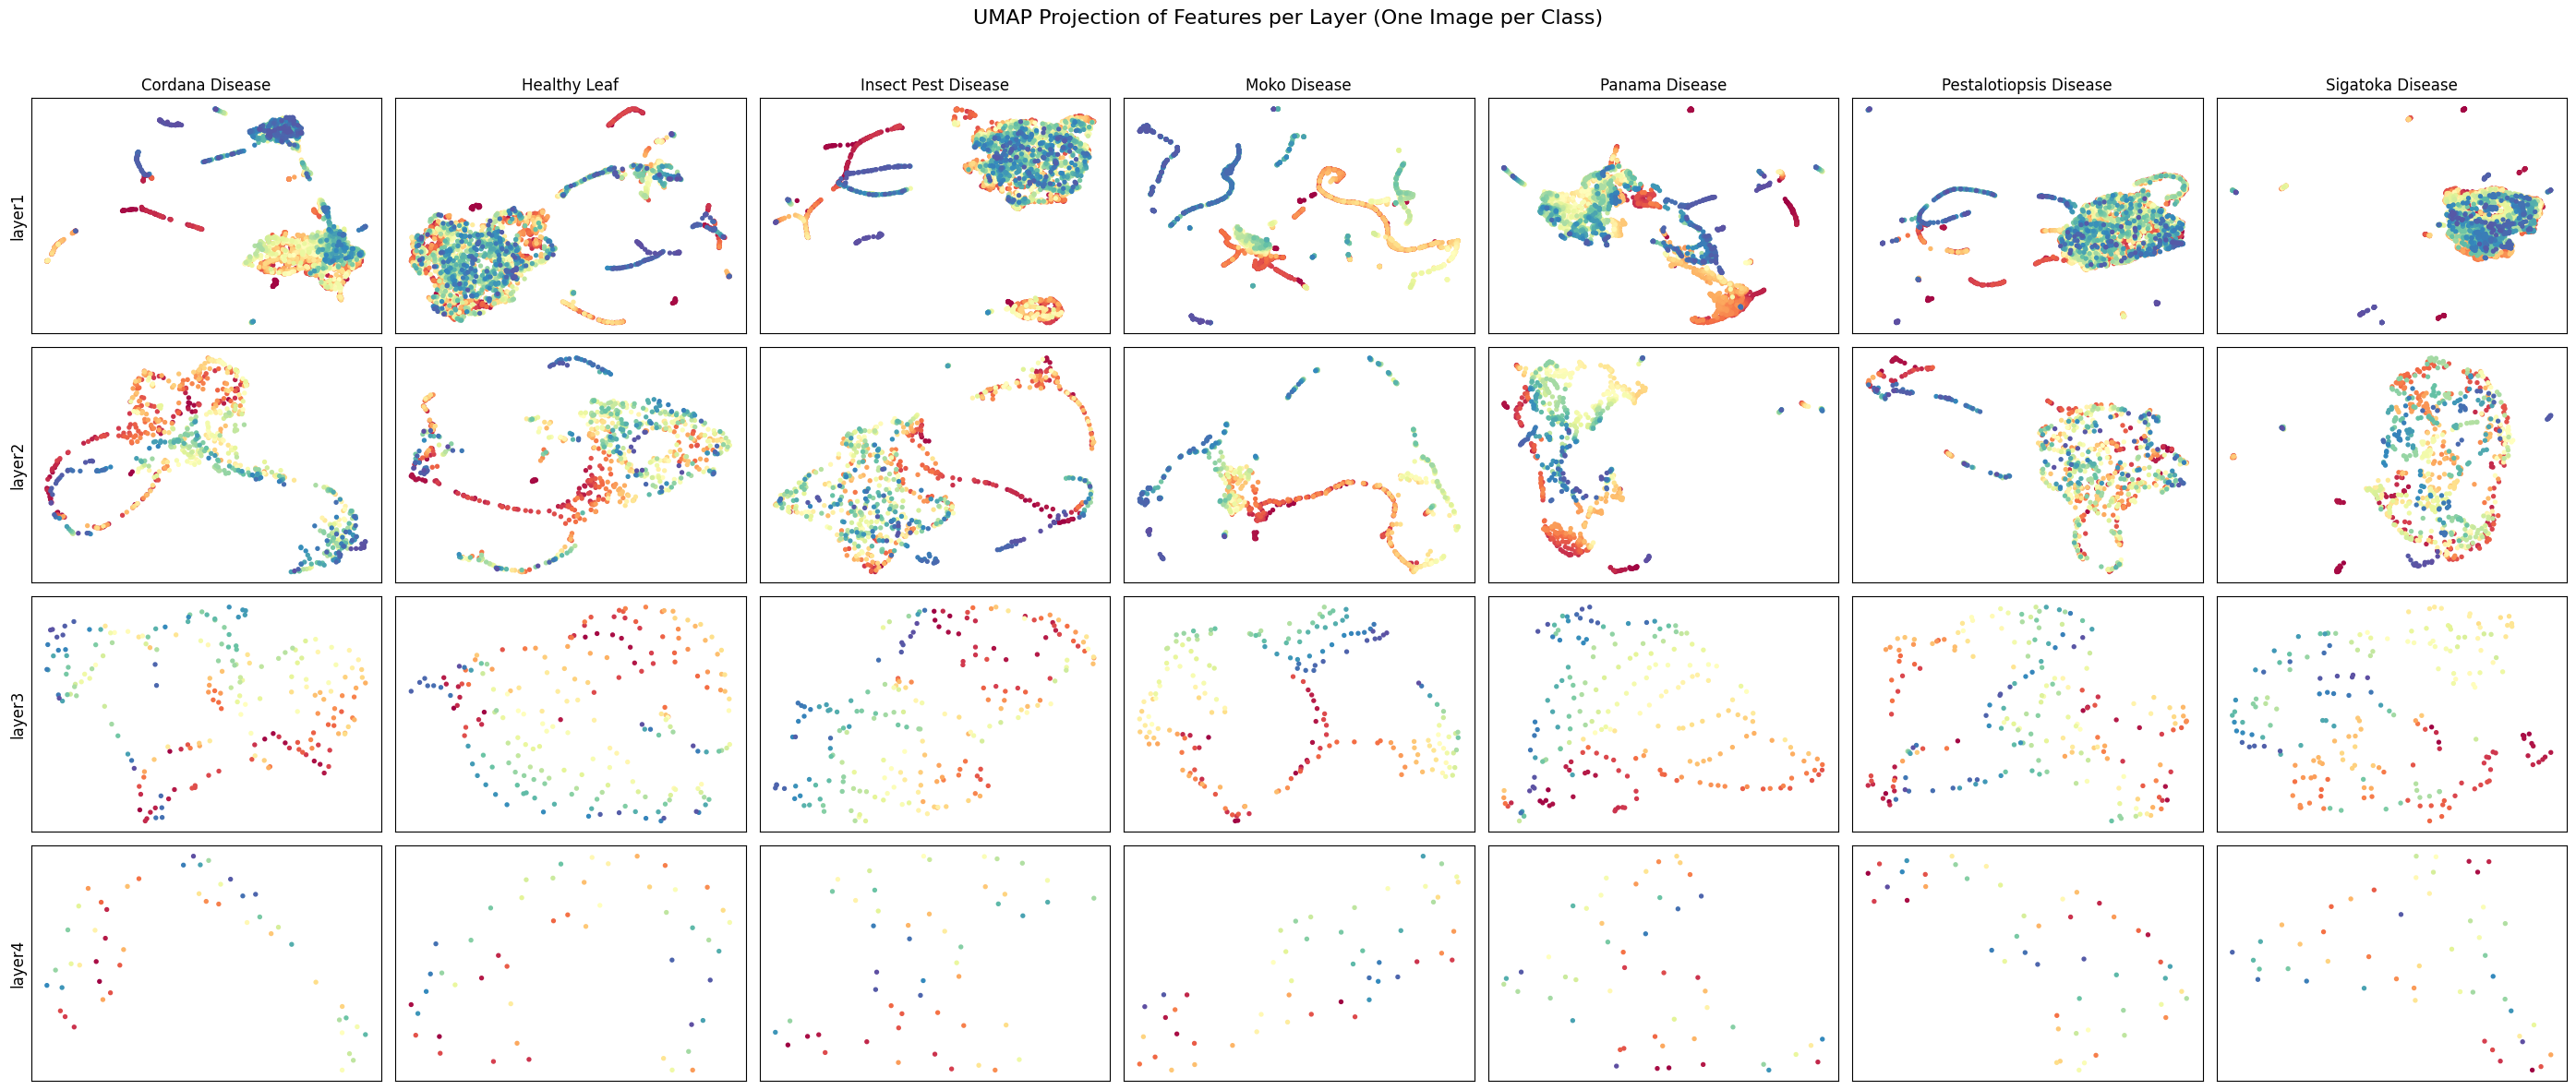

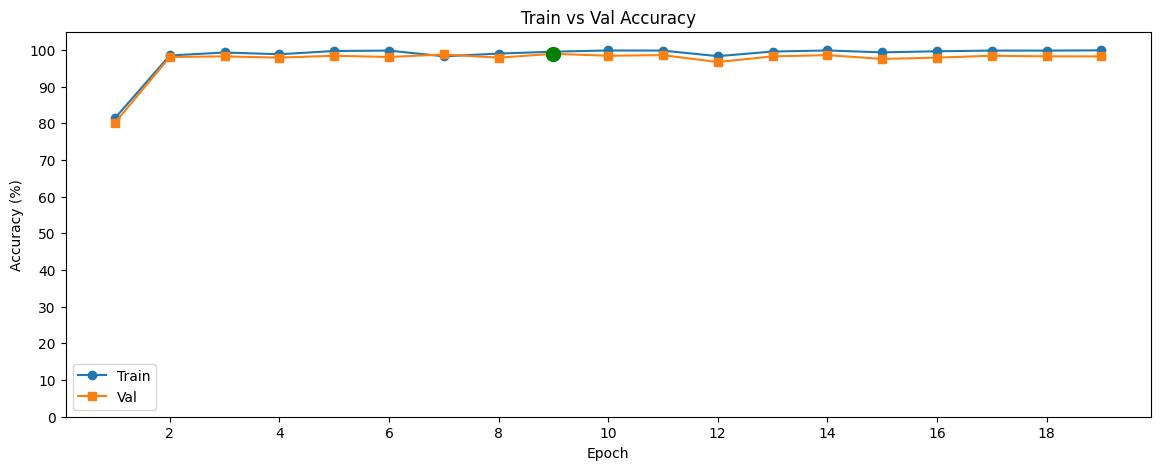

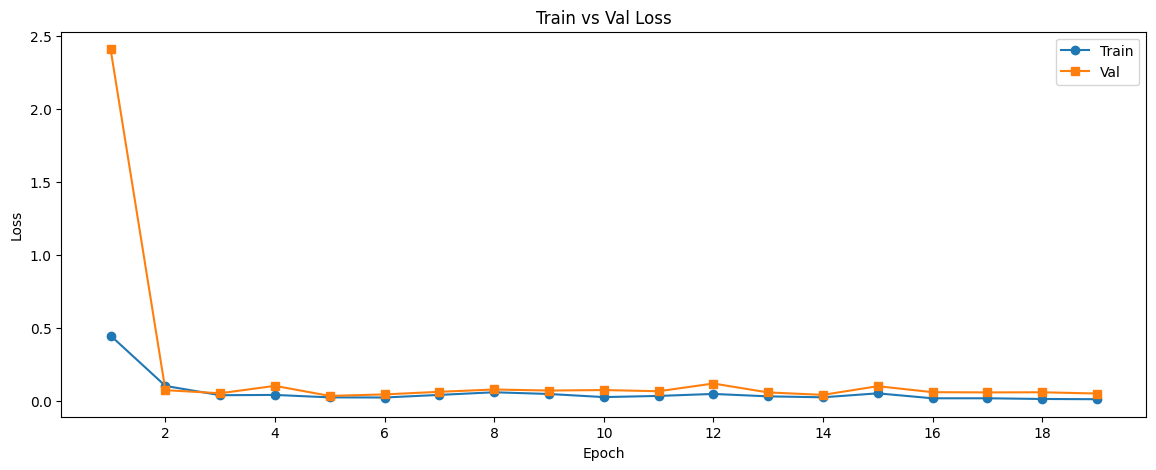

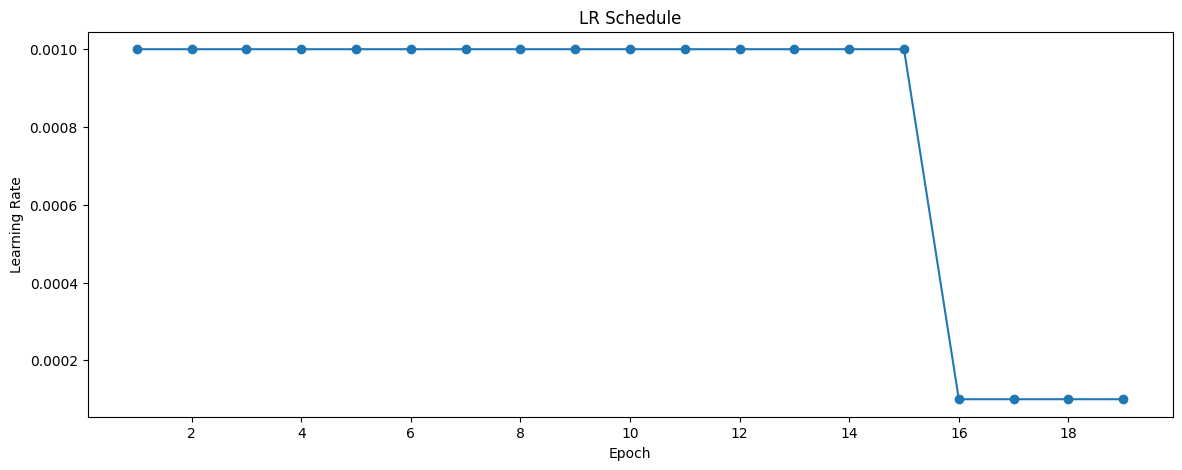

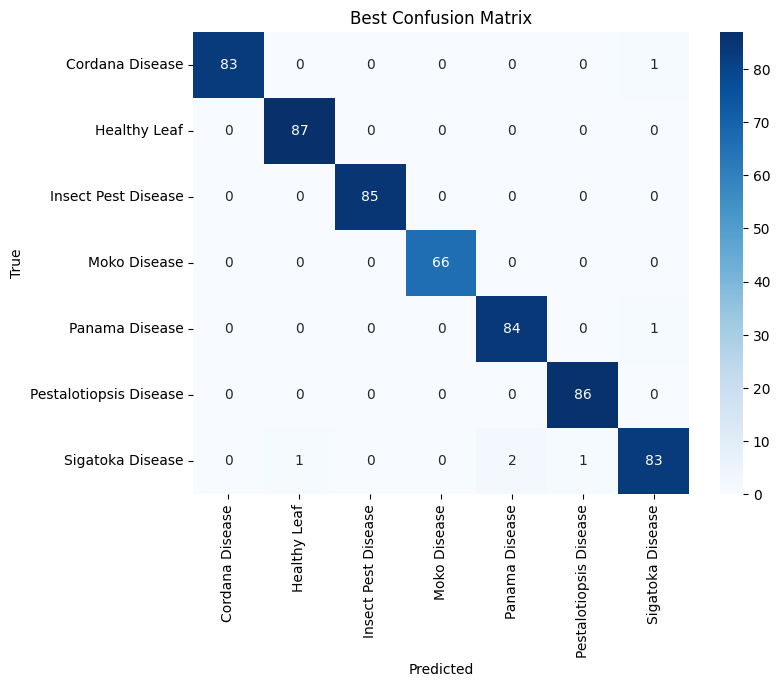

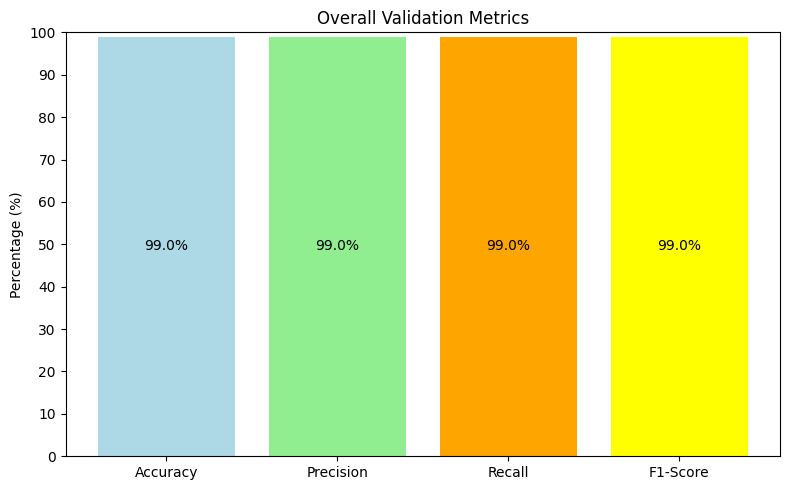

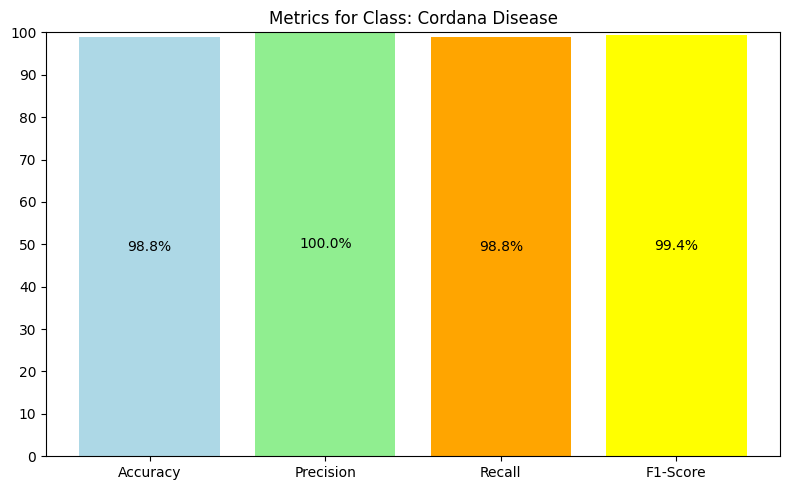

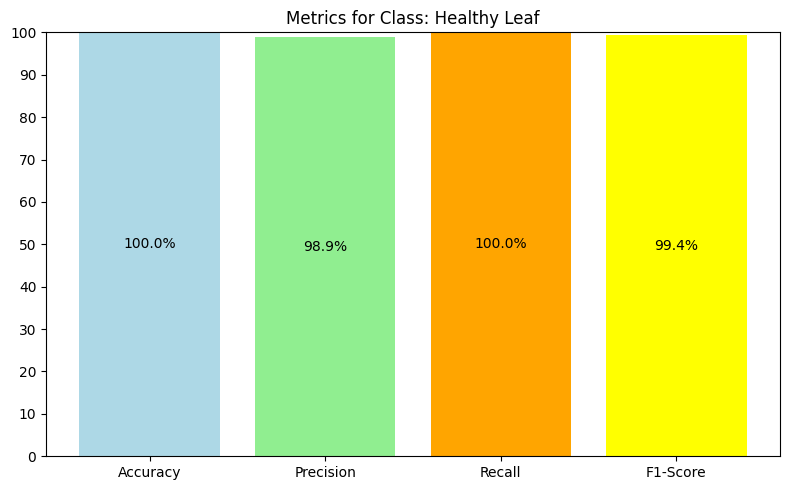

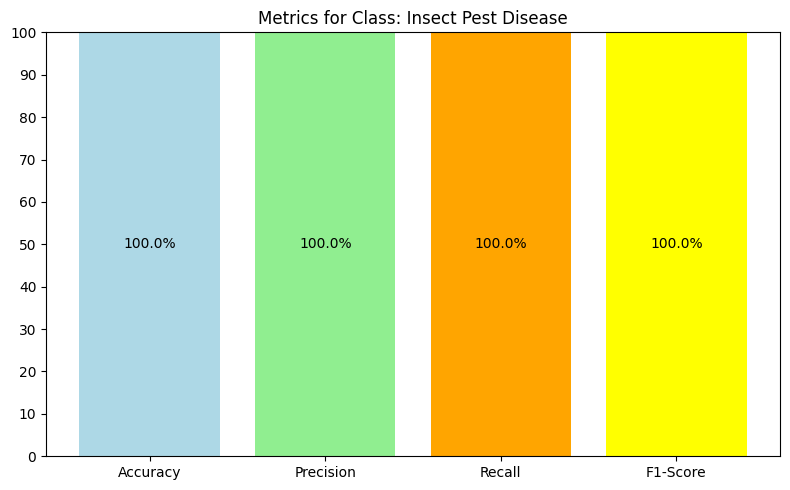

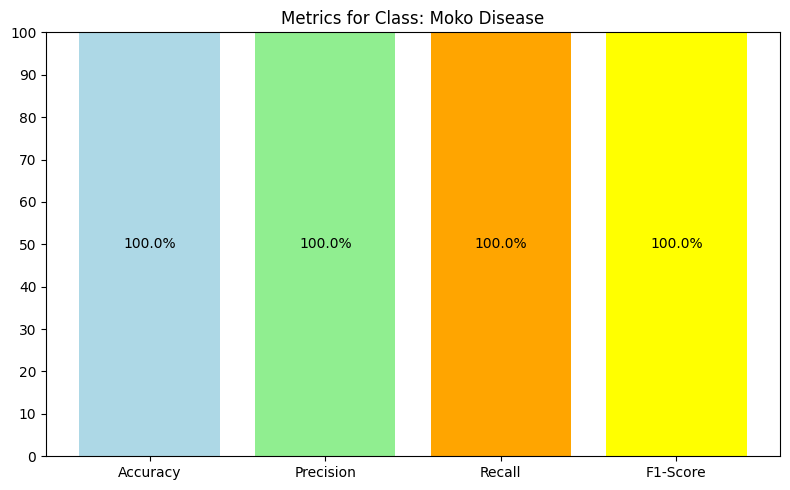

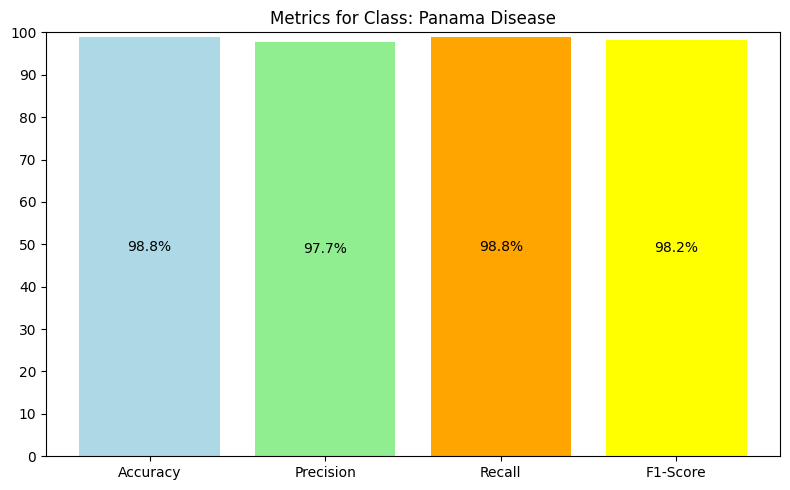

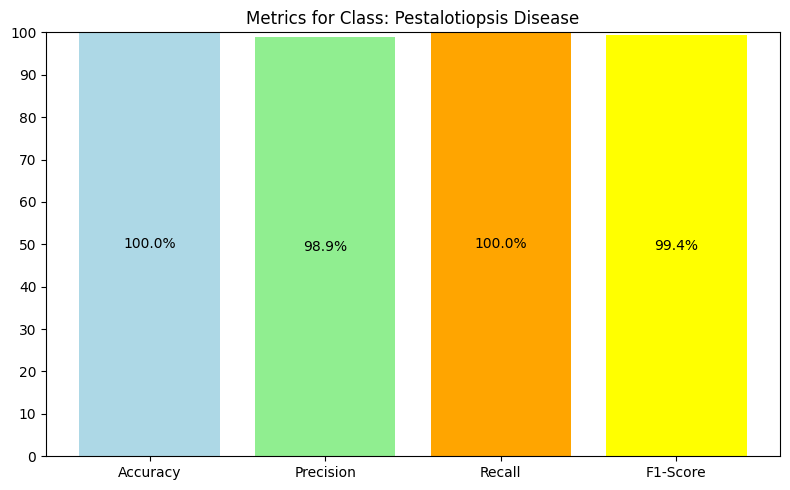

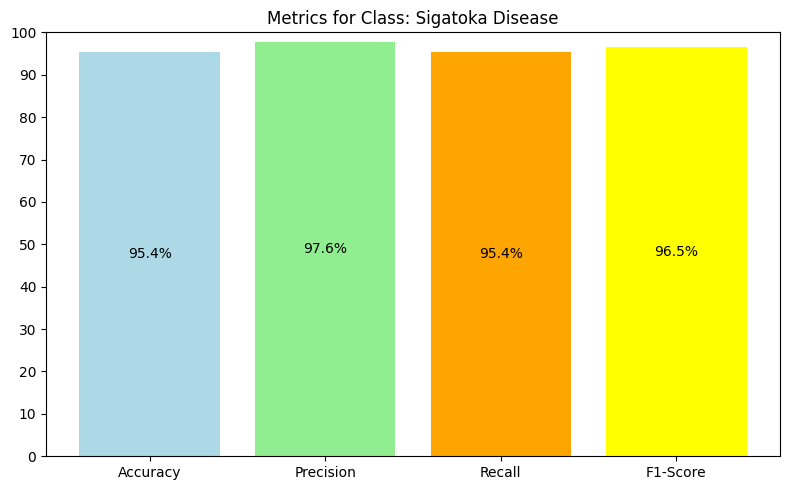

In [2]:
import os
import time
import random
import copy
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torch.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import umap

# --------------------
# Configurable params
# --------------------
SEED = 42
num_epochs = 100           # change this to set number of epochs
drop_out_rate = 0.3        # dropout rate for classifier
early_stopping_patience = 10

# --------------------
# Device & reproducibility
# --------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
g = torch.Generator(); g.manual_seed(SEED)

# --------------------
# Dataset w/ CLAHE
# --------------------
class BananaDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        orig = cv2.imread(self.image_paths[idx])
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
        image = self.apply_clahe(orig)
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

    def apply_clahe(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        l, a, b = cv2.split(lab)
        cl = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(l)
        merged = cv2.merge((cl, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_Lab2RGB)

# --------------------
# Transforms
# --------------------
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_transform = transforms.Compose([  # no augmentation
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# --------------------
# Accuracy & validation
# --------------------
def compute_train_accuracy(model, loader):
    model.eval()
    preds, labs = [], []
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            with autocast(device_type=device.type):
                out = model(x)
            _, p = torch.max(out,1)
            preds.extend(p.cpu().numpy())
            labs.extend(y.cpu().numpy())
    model.train()
    return accuracy_score(labs, preds)

def validate_model(model, loader, criterion):
    model.eval()
    preds, labs = [], []
    running_loss = 0.0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            with autocast(device_type=device.type):
                out = model(x)
                loss = criterion(out, y)
            running_loss += loss.item()
            _, p = torch.max(out,1)
            preds.extend(p.cpu().numpy())
            labs.extend(y.cpu().numpy())
    model.train()
    return (accuracy_score(labs, preds),
            running_loss/len(loader),
            confusion_matrix(labs, preds))

# --------------------
# Plotting helpers
# --------------------
def plot_accuracy_curve(train_accs, val_accs):
    eps = list(range(1,len(train_accs)+1))
    ta = [a*100 for a in train_accs]; va = [v*100 for v in val_accs]
    fig,ax = plt.subplots(figsize=(14,5))
    ax.plot(eps, ta, marker='o')
    ax.plot(eps, va, marker='s')
    bi = int(np.argmax(va)); bv = va[bi]
    ax.scatter(bi+1, bv, color='green', s=100, zorder=5)
    ax.set(xlabel='Epoch', ylabel='Accuracy (%)', title='Train vs Val Accuracy')
    ax.legend(['Train','Val'])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(0,105); ax.set_yticks(np.arange(0,106,10))
    plt.show()

def plot_loss_curve(tr_losses, val_losses):
    eps = list(range(1,len(tr_losses)+1))
    fig,ax = plt.subplots(figsize=(14,5))
    ax.plot(eps, tr_losses, marker='o'); ax.plot(eps, val_losses, marker='s')
    ax.set(xlabel='Epoch', ylabel='Loss', title='Train vs Val Loss')
    ax.legend(['Train','Val'])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def plot_lr_curve(lrs):
    eps = list(range(1,len(lrs)+1))
    fig,ax = plt.subplots(figsize=(14,5))
    ax.plot(eps, lrs, marker='o')
    ax.set(xlabel='Epoch', ylabel='Learning Rate', title='LR Schedule')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def plot_confusion(cm, labels):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Best Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

def compute_class_metrics(cm):
    n = cm.shape[0]
    acc = np.zeros(n); prec = np.zeros(n); rec = np.zeros(n); f1 = np.zeros(n)
    for i in range(n):
        TP = cm[i,i]
        FP = cm[:,i].sum() - TP
        FN = cm[i,:].sum() - TP
        acc[i] = TP/(cm[i,:].sum()+1e-6)
        prec[i] = TP/(TP+FP+1e-6)
        rec[i] = TP/(TP+FN+1e-6)
        f1[i] = 2*prec[i]*rec[i]/(prec[i]+rec[i]+1e-6)
    return acc, prec, rec, f1

def plot_class_wise_metrics(cm, class_names):
    acc, prec, rec, f1 = compute_class_metrics(cm)
    metrics = ['Accuracy','Precision','Recall','F1-Score']
    colors = ['lightblue','lightgreen','orange','yellow']
    for i,name in enumerate(class_names):
        vals = [acc[i]*100, prec[i]*100, rec[i]*100, f1[i]*100]
        fig,ax = plt.subplots(figsize=(8,5))
        bars = ax.bar(metrics, vals, color=colors)
        for bar,v in zip(bars, vals):
            # center text inside bar
            h = bar.get_height()
            ax.text(bar.get_x()+bar.get_width()/2, h*0.5, f'{v:.1f}%',
                    ha='center', va='center')
        ax.set_ylim(0,100); ax.set_yticks(np.arange(0,101,10))
        ax.set_title(f'Metrics for Class: {name}')
        plt.tight_layout(); plt.show()

def plot_overall_metrics(acc, prec, rec, f1):
    labs = ['Accuracy','Precision','Recall','F1-Score']
    vals = [acc*100, prec*100, rec*100, f1*100]
    cols = ['lightblue','lightgreen','orange','yellow']
    fig,ax = plt.subplots(figsize=(8,5))
    bars = ax.bar(labs, vals, color=cols)
    for bar,v in zip(bars, vals):
        h = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2, h*0.5, f'{v:.1f}%',
                ha='center', va='center')
    ax.set_ylim(0,100); ax.set_yticks(np.arange(0,101,10))
    ax.set_ylabel('Percentage (%)'); ax.set_title('Overall Validation Metrics')
    plt.tight_layout(); plt.show()

# --------------------
# CLAHE + Augmented display
# --------------------
def display_original_and_preprocessed_images(paths, labels, transform, classnames):
    dataset = BananaDiseaseDataset(paths, labels, transform=None)
    n = len(classnames)
    fig,axes = plt.subplots(2, n, figsize=(4*n, 8))
    fig.suptitle('Original (Top) vs CLAHE + Augmented (Bottom)', fontsize=16)
    for i, cls in enumerate(classnames):
        idx = next((j for j,l in enumerate(labels) if l==i), None)
        orig = cv2.cvtColor(cv2.imread(paths[idx]), cv2.COLOR_BGR2RGB)
        clahe_img = dataset.apply_clahe(orig)
        aug_img = transform(clahe_img).permute(1,2,0).numpy()
        aug_img = np.clip(
            aug_img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]),
            0, 1
        )
        axes[0,i].imshow(orig); axes[0,i].set_title(cls); axes[0,i].axis('off')
        axes[1,i].imshow(aug_img); axes[1,i].axis('off')
    plt.tight_layout(rect=[0,0,1,0.96]); plt.show()

# --------------------
# UMAP visualization
# --------------------
def extract_features_for_umap(model, img_tensor, layers):
        extractor = create_feature_extractor(model, return_nodes=layers)
        with torch.no_grad():
            with autocast(device_type=device.type):
                features = extractor(img_tensor)
        return features

def visualize_umap_features(model, class_names, image_paths, labels, transform, layers):
        fig, axes = plt.subplots(len(layers), len(class_names),
                                 figsize=(4*len(class_names), 3*len(layers)))
        fig.suptitle("UMAP Projection of Features per Layer (One Image per Class)", fontsize=16)

        for c_idx, cls in enumerate(class_names):
            img_idx = next((j for j, l in enumerate(labels) if l == c_idx), None)
            if img_idx is None: continue

            img = cv2.imread(image_paths[img_idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            tensor = transform(img).unsqueeze(0).to(device)

            feat_maps = extract_features_for_umap(model, tensor, layers)

            for l_idx, layer in enumerate(layers):
                fmap = feat_maps[layer].squeeze(0)          # [C, H, W]
                fmap_flat = fmap.view(fmap.size(0), -1)    # [C, H*W]
                data = fmap_flat.permute(1, 0).cpu().numpy()  # [H*W, C]

                reducer = umap.UMAP(n_neighbors=10, min_dist=0.1)
                emb = reducer.fit_transform(data)

                ax = axes[l_idx][c_idx]
                ax.scatter(emb[:, 0], emb[:, 1], c=np.arange(len(emb)), cmap='Spectral', s=8)
                if c_idx == 0:
                    ax.set_ylabel(layer, fontsize=12)
                if l_idx == 0:
                    ax.set_title(cls, fontsize=12)
                ax.set_xticks([]); ax.set_yticks([])

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# --------------------
# Main
# --------------------
def main():
    train_dir = "/kaggle/input/bld-7-classes/7-Classes_Dataset/train"
    val_dir   = "/kaggle/input/bld-7-classes/7-Classes_Dataset/val"
    chft_ckpt = "/kaggle/working/chft-ResNet50.pth"
    ckpt      = "/kaggle/working/chLayer4ft-ResNet50.pth"

    def load_ds(f):
        ps,ls = [],[]
        cls = sorted(d for d in os.listdir(f) if os.path.isdir(os.path.join(f,d)))
        for i,c in enumerate(cls):
            for fn in os.listdir(os.path.join(f,c)):
                if fn.lower().endswith(('png','jpg','jpeg')):
                    ps.append(os.path.join(f,c,fn)); ls.append(i)
        return ps, ls, cls

    train_paths, train_labels, classnames = load_ds(train_dir)
    val_paths,   val_labels,   _           = load_ds(val_dir)

    train_loader = DataLoader(
        BananaDiseaseDataset(train_paths, train_labels, train_transform),
        batch_size=128, shuffle=True, pin_memory=True, generator=g,num_workers=4, persistent_workers=True)
    
    val_loader = DataLoader(
        BananaDiseaseDataset(val_paths, val_labels, val_transform),
        batch_size=128, shuffle=False, pin_memory=True, generator=g,num_workers=4, persistent_workers=True)

    # Model setup
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    in_f = model.fc.in_features
    
    model.fc = nn.Sequential(
        nn.Dropout(drop_out_rate),
        nn.Linear(in_f, len(classnames))
    )

    model = model.to(device)

    state = torch.load(chft_ckpt, map_location=device)
    model.load_state_dict(state)
    print(f"✅ Loaded best checkpoint from {chft_ckpt}")

    for p in model.parameters(): p.requires_grad=False

    for p in model.layer4.parameters(): p.requires_grad=True

    for p in model.fc.parameters(): p.requires_grad=True

    
    # Criterion, optimizer, scheduler, scaler
    cw = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(cw,dtype=torch.float).to(device))
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4) #0.001 current lr -> after 5 epochs if val acc is not improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
    scaler = GradScaler()

    best_acc, best_cm, best_w = 0.0, None, None
    no_imp = 0
    ta, va, tl, vl, lr_list = [], [], [], [], []

    print("Training with mixed precision (AMP)…")
    t0 = time.time()
    for epoch in range(num_epochs):
        e0 = time.time()
        # Train
        model.train(); run_loss = 0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast(device_type=device.type):
                out = model(x); loss = criterion(out,y)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            run_loss += loss.item()
        tr_loss = run_loss/len(train_loader); tl.append(tr_loss)
        lr_list.append(optimizer.param_groups[0]['lr'])
        tr_acc = compute_train_accuracy(model, train_loader); ta.append(tr_acc)

        # Validate
        val_acc, val_loss, cm = validate_model(model, val_loader, criterion)
        va.append(val_acc); vl.append(val_loss)

        # Log
        et = time.time()-e0; m,s = divmod(int(et),60)
        lr_str = f"{optimizer.param_groups[0]['lr']:.0e}"
        print(
            f"Epoch [{epoch+1}/{num_epochs}]  "
            f"tloss: {tr_loss:.4f}  "
            f"tacc: {tr_acc*100:.2f}%  "
            f"vloss: {val_loss:.4f}  "
            f"vacc: {val_acc*100:.2f}%  "
            f"lr: {lr_str}  "
            f"time: {m}m {s}s"
        )

        # Early stopping & checkpoint
        if val_acc > best_acc:
            best_acc, best_cm = val_acc, cm
            best_w = copy.deepcopy(model.state_dict()); no_imp = 0
            torch.save(best_w, ckpt)
            print(f"→ New best validation accuracy: {best_acc*100:.2f}% at epoch {epoch+1}")
        else:
            no_imp += 1
            print(f"No improvement. Patience: {no_imp}/{early_stopping_patience}")
            if no_imp >= early_stopping_patience:
                print("Early stopping triggered.")
                break
        scheduler.step(val_acc)

    # End training
    tot = time.time() - t0
    h,m,s = int(tot//3600), int((tot%3600)//60), int(tot%60)
    print(f"\nTotal training time: {h}h {m}m {s}s")
    print(f"Best Validation Accuracy: {best_acc*100:.2f}%")

    # Reload best weights
    model.load_state_dict(best_w)
    model.eval()

    # 4) CLAHE + Augmented display
    display_original_and_preprocessed_images(
        train_paths, train_labels, train_transform, classnames
    )

    # 5) UMAP
    feature_layers = [
        'layer1', 'layer2', 
        'layer3', 'layer4'
    ]
    visualize_umap_features(
        model, classnames, train_paths, train_labels,
        train_transform, feature_layers
    )

    # 6) accuracy curve
    plot_accuracy_curve(ta, va)
    # 7) loss curve
    plot_loss_curve(tl, vl)
    # 8) lr curve
    plot_lr_curve(lr_list)
    # 9) best confusion matrix
    plot_confusion(best_cm, classnames)

    # 10) bar graphs
    y_t, y_p = [], []
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x); _, pr = torch.max(out,1)
            y_t.extend(y.cpu().numpy()); y_p.extend(pr.cpu().numpy())
    op = precision_score(y_t, y_p, average='macro')
    orc = recall_score(y_t, y_p, average='macro')
    of1 = f1_score(y_t, y_p, average='macro')
    plot_overall_metrics(best_acc, op, orc, of1)
    plot_class_wise_metrics(best_cm, classnames)

if __name__=="__main__":
    main()
